In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/Ass

/content/gdrive/MyDrive/Ass


In [65]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import heapq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, confusion_matrix
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split #import the train_test_split splitting the dataset to training and testing dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics

import pdb

In [5]:
def readdata(dataname, Flag=False):
    data_path = './'+dataname+'/'
    
    if dataname == 'ml-100k':
        
        #User's data
        users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
        users = pd.read_csv(data_path+'u.user', sep='|', names=users_cols, parse_dates=True)
        #Ratings
        rating_cols = ['userId', 'movieId', 'rating', 'time']
        ratings = pd.read_csv(data_path+'u.data', sep='\t', names=rating_cols)
        #Movies
        movie_cols = ['movie_id', 'title', 'release_year', 'video_release_date', 'imdb_url']
        movies = pd.read_csv(data_path+'u.item', sep='|', names=movie_cols, usecols=range(5),encoding='latin-1')
    else:
        ratings = pd.read_csv(data_path+'ratings.csv')
    
    #users = np.loadtxt(data_path+'u.user', delimiter='|')
    #ratings = np.loadtxt(data_path+'u.data')
    #movies = np.loadtxt(data_path+'u.item', delimiter='|')
    #print(f'shape -> users:{users.shape}, ratings: {ratings.shape}, movies: {movies.shape}')
    #print(type(ratings))
    
    #breakpoint()
    
    if Flag:
        ratings = ratings.iloc[0:4000,:].copy()
    else:
        pass
    
    
    return ratings

In [6]:
df = readdata('ml-100k')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   100000 non-null  int64
 1   movieId  100000 non-null  int64
 2   rating   100000 non-null  int64
 3   time     100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [8]:
df.head()

,userId,movieId,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
movie_cols = ['movieId', 'title', 'release_year', 'video_release_date', 'imdb_url']
movies = pd.read_csv('./ml-100k/u.item', sep='|', names=movie_cols, usecols=range(5),encoding='latin-1')

In [10]:
movies.head()

,movieId,title,release_year,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [11]:
len(df.movieId.unique()) 

1682

In [12]:
len(movies.movieId.unique())

1682

In [13]:
len(movies.title.unique())

1664

In [14]:
movies[movies.title.duplicated(keep=False)].sort_values(by='title')

,movieId,title,release_year,video_release_date,imdb_url
669,670,Body Snatchers (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Body%20Snatch...
572,573,Body Snatchers (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Body%20Snatch...
1649,1650,"Butcher Boy, The (1998)",01-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...
1644,1645,"Butcher Boy, The (1998)",01-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...
1233,1234,Chairman of the Board (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Chairman+of+the+Board...
1653,1654,Chairman of the Board (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Chairman+of+the+Board...
245,246,Chasing Amy (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Chasing+Amy+(...
267,268,Chasing Amy (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Chasing+Amy+(...
1605,1606,Deceiver (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Liar+(1997)
308,309,Deceiver (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Liar+(1997)


In [15]:
df = pd.merge(df, movies, on='movieId')
df.head()

,userId,movieId,rating,time,title,release_year,video_release_date,imdb_url
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)


In [16]:
df.tail()

,userId,movieId,rating,time,title,release_year,video_release_date,imdb_url
99995,840,1674,4,891211682,Mamma Roma (1962),01-Jan-1962,NaN,http://us.imdb.com/M/title-exact?Mamma%20Roma%...
99996,655,1640,3,888474646,"Eighth Day, The (1996)",01-Nov-1996,NaN,"http://us.imdb.com/Title?Huiti%E8me+jour,+Le+(..."
99997,655,1637,3,888984255,Girls Town (1996),23-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Girls%20Town%...
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1...",02-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Saimt%20el%20...
99999,655,1641,3,887427810,Dadetown (1995),18-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Dadetown%20(1...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userId              100000 non-null  int64  
 1   movieId             100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   time                100000 non-null  int64  
 4   title               100000 non-null  object 
 5   release_year        99991 non-null   object 
 6   video_release_date  0 non-null       float64
 7   imdb_url            99987 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 6.9+ MB


In [18]:
print(df[df.title=="Body Snatchers (1993)"])

       userId  movieId  rating       time                  title release_year  \
73128      38      573       1  892433660  Body Snatchers (1993)  01-Jan-1993   
73129     312      573       5  891712535  Body Snatchers (1993)  01-Jan-1993   
73130      95      573       1  888954808  Body Snatchers (1993)  01-Jan-1993   
73131     339      573       3  891036016  Body Snatchers (1993)  01-Jan-1993   
73132     254      573       2  886475476  Body Snatchers (1993)  01-Jan-1993   
...       ...      ...     ...        ...                    ...          ...   
74127     776      670       3  892920351  Body Snatchers (1993)  01-Jan-1993   
74128     650      670       3  891387915  Body Snatchers (1993)  01-Jan-1993   
74129     897      670       3  879991258  Body Snatchers (1993)  01-Jan-1993   
74130     788      670       3  880870935  Body Snatchers (1993)  01-Jan-1993   
74131     802      670       4  875986155  Body Snatchers (1993)  01-Jan-1993   

       video_release_date  

In [19]:
df.head()

,userId,movieId,rating,time,title,release_year,video_release_date,imdb_url
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)


In [20]:
df.groupby('title')['rating'].mean()

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [21]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64

In [22]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [23]:
ratings_df = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_df.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [24]:
ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
ratings_df.head(3)

,average_rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257


In [25]:
ratings_df['num_of_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_df.head()

,average_rating,num_of_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Text(0, 0.5, 'number of films with that many ratings')

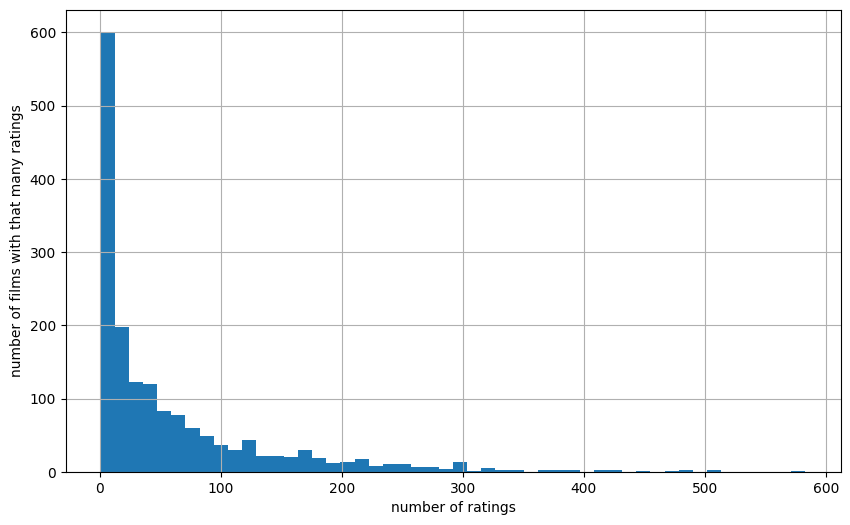

In [26]:
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

Text(0, 0.5, 'number of films with that rating')

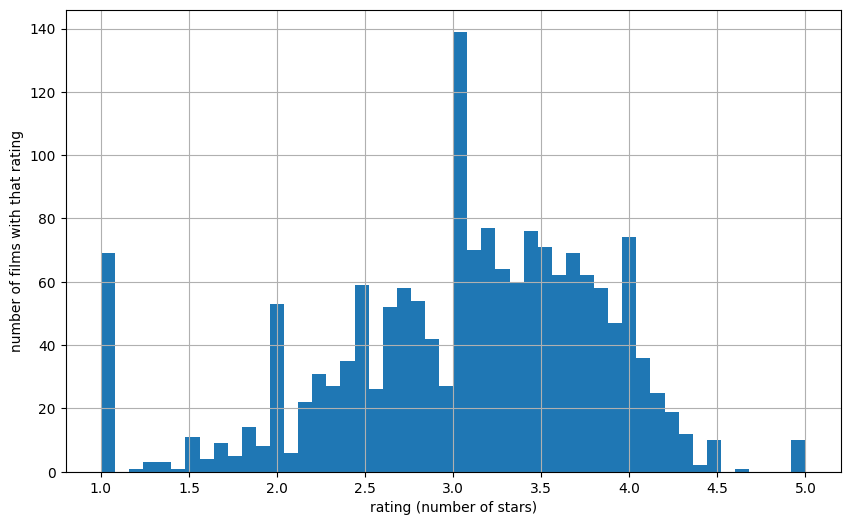

In [27]:
plt.figure(figsize=[10,6])
ratings_df.average_rating.hist(bins=50)
plt.xlabel('rating (number of stars)')
plt.ylabel('number of films with that rating')

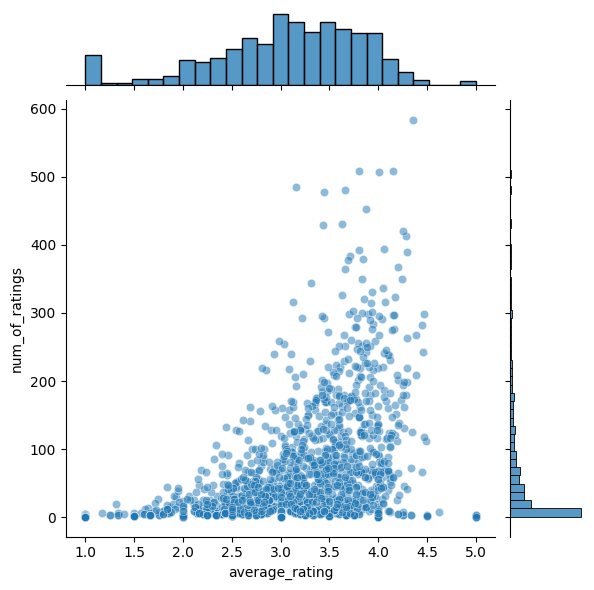

In [28]:
sns.jointplot(x='average_rating',y='num_of_ratings', data=ratings_df, alpha=0.5)

In [29]:
df.head()

,userId,movieId,rating,time,title,release_year,video_release_date,imdb_url
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996)


In [30]:
len(df.groupby(by='title')['rating'].count())

1664

In [31]:
user_movie_matrix = df.pivot_table(values='rating' , index='userId' , columns='title' )
user_movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [32]:
ratings_df.sort_values(by='num_of_ratings', ascending=False).head()

,average_rating,num_of_ratings
title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


In [33]:
starwars_user_ratings = user_movie_matrix['Star Wars (1977)']
fargo_user_ratings = user_movie_matrix['Fargo (1996)']

In [34]:
starwars_user_ratings.head(15)

userId
1     5.0
2     5.0
3     NaN
4     5.0
5     4.0
6     4.0
7     5.0
8     5.0
9     5.0
10    5.0
11    NaN
12    4.0
13    5.0
14    5.0
15    5.0
Name: Star Wars (1977), dtype: float64

In [35]:
fargo_user_ratings.head()

userId
1    5.0
2    5.0
3    NaN
4    NaN
5    5.0
Name: Fargo (1996), dtype: float64

In [36]:
type(user_movie_matrix), type(user_movie_matrix['Star Wars (1977)' ]), type(starwars_user_ratings)

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [37]:
similar_to_starwars = user_movie_matrix.corrwith(starwars_user_ratings)
similar_to_starwars.head()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [38]:
similar_to_starwars.shape

(1664,)

In [39]:
similar_to_fargo = user_movie_matrix.corrwith(fargo_user_ratings)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [40]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])

In [41]:
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
3 Ninjas: High Noon At Mega Mountain (1998),NaN


In [42]:
corr_starwars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1664 entries, 'Til There Was You (1997) to Á köldum klaka (Cold Fever) (1994)
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Correlation  1410 non-null   float64
dtypes: float64(1)
memory usage: 90.5+ KB


In [43]:
corr_starwars.dropna(inplace=True)
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


In [44]:
corr_starwars.sort_values(by='Correlation', ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Text(0, 0.5, 'number of films with that many ratings')

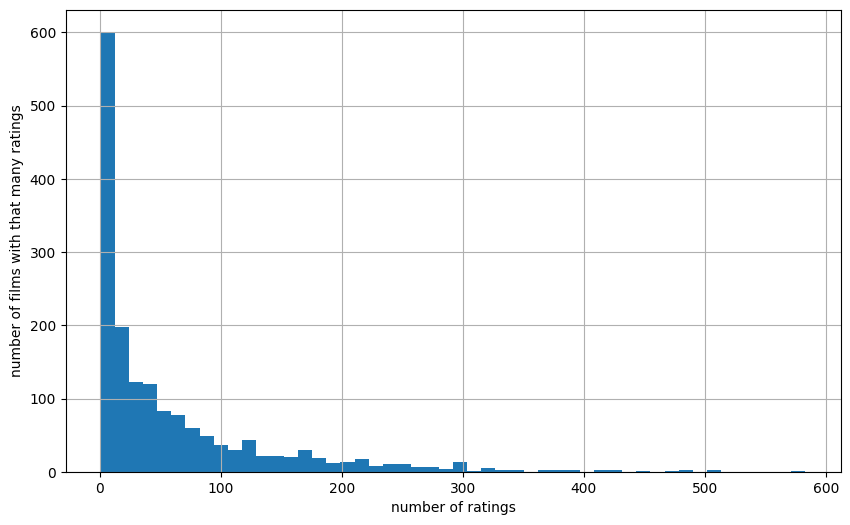

In [45]:
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

In [46]:
corr_starwars = corr_starwars.join(ratings_df['num_of_ratings'])
corr_starwars.head()

,Correlation,num_of_ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [47]:
new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 50]

In [48]:
new_corr_starwars.head(10)

,Correlation,num_of_ratings
title,,
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
2 Days in the Valley (1996),0.066654,93
"20,000 Leagues Under the Sea (1954)",0.289768,72
2001: A Space Odyssey (1968),0.230884,259
"39 Steps, The (1935)",0.106453,59
Absolute Power (1997),0.085440,127
"Abyss, The (1989)",0.203709,151
Ace Ventura: Pet Detective (1994),0.062689,103


In [49]:
new_corr_starwars.sort_values('Correlation',ascending=False).head(20)

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Giant (1956),0.488093,51
"Life Less Ordinary, A (1997)",0.411638,53
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331


In [50]:
new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 100]
new_corr_starwars.sort_values('Correlation',ascending=False).head(20)

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [51]:
def recommender(film_x, min_num_reviews):
    
    # Get user ratings for film
    film_x_user_ratings = user_movie_matrix[film_x]
    # Create pandas series of correlations for all films with film_x
    similar_to_film_x = user_movie_matrix.corrwith(film_x_user_ratings)
    # Convert to df
    corr_film_x = pd.DataFrame(similar_to_film_x, columns=['Correlation'])
    # Drop nulls
    corr_film_x.dropna(inplace=True)
    # Join ratings info to enbale filtering of films with low nums of ratings
    corr_film_x = corr_film_x.join(ratings_df['num_of_ratings'])
    # Apply filter
    new_corr_film_x = corr_film_x[corr_film_x['num_of_ratings'] >= min_num_reviews]
    # Sort intp ascending order
    return new_corr_film_x.sort_values('Correlation',ascending=False).head(20)

In [52]:
recommender('Star Wars (1977)', 100)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [53]:
recommender('Fargo (1996)', 200)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Fargo (1996),1.000000,508
"People vs. Larry Flynt, The (1996)",0.341784,215
Stand by Me (1986),0.332730,227
Amadeus (1984),0.308669,276
2001: A Space Odyssey (1968),0.299882,259
"Graduate, The (1967)",0.295198,239
Raising Arizona (1987),0.293711,256
Young Frankenstein (1974),0.287904,200
"Clockwork Orange, A (1971)",0.279690,221


In [54]:
# Defining lists for the training and test datasets
train_data = []
train_label = []
test_data = []
test_label = []

In [55]:
from heading_v1 import *

In [56]:
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [57]:
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 80000
No. of testing examples: 20000


In [63]:
model = recommender(training_data, 100)

In [ ]:
mae = mean_absolute_error(targets, predictions)
rmse = mean_squared_error(targets, predictions, squared=False)
recall = recall_score(targets, [1 if p>= 0.5 else 0 for p in predictions], average=None, zero_division=1)
precision = precision_score(targers, [1 if p>= 0.5 else 0 for p in predictions], average=None, zero_division=1)

In [67]:
def makedata(ratings, Flag=False):
    rating_table = ratings.pivot_table(values='rating', index='userId', columns='movieId',fill_value=0)
    #rating_table_test = ratings.pivot_table(values='rating', index='user_id', columns='movie_id',fill_value=0)
    
    # test
    if Flag:
        rating_table = rating_table.iloc[0:6, 0:20]
    else:
        pass
    
    return rating_table

def cosinesim(userI, userJ):
    sim_ij = np.dot(userI,userJ) / (norm(userI)*norm(userJ))
    
    return sim_ij

def getsimilarity(num_user, rating_table):
    #cos_sim = cosine_similarity([rating_table.iloc[userX,:]], [rating_table.iloc[userY,:]])
    rating_table_sparse = sparse.csr_matrix(rating_table)
    sim = cosine_similarity(rating_table_sparse)
    #sim = cosine_similarity(rating_table)
    
    """
    sim = np.zeros([num_user,num_user])
    for userI in range(num_user):
        for userJ in range(num_user):
            if userI == userJ:
                sim[userI,userJ] = 1.0
            else:
                sim[userI,userJ] = cosinesim(rating_table.iloc[userI,:],rating_table.iloc[userJ,:])
                sim[userJ,userI] = sim[userI,userJ]
    
        breakpoint()
    """
    return sim

def getsimusers(num_user, topN, sim):
    
    for i in range(num_user):
        sim_useri = sim[i,:]
        arg_sorted = np.argsort(-sim_useri)
        arg_sim_users_useri = arg_sorted[1:topN+1]
        
        #print(arg_sim_users_useri)
        
        if i == 0:
            arg_sim_users = arg_sim_users_useri.reshape(1,topN)
        else:
            arg_sim_users = np.append(arg_sim_users,arg_sim_users_useri.reshape(1,topN), axis=0)
        
        #breakpoint()
        
            
    return arg_sim_users

def getpred(num_item,num_user, topN, topN_sim_users, sim, rating_table):
    k = 0
    for userI in range(num_user):
        # normalisation
        k = sum([sim[userI,simuser] for simuser in topN_sim_users[userI,:]])
        #print(f'userI: {userI}, k: {k}')
        
        
        for itemJ in range(num_item):
            pred_userI_itemJ = 0
            
            #breakpoint()
            
            #pred_userI_itemJ = sum([rating_table.iloc[topN_sim_users[userI,k],itemJ] * sim[userI,topN_sim_users[userI,k]] for k in range(topN)])
            pred_userI_itemJ = sum([rating_table.iloc[topN_sim_users[userI,k],itemJ] * sim[userI,topN_sim_users[userI,k]] for k in range(topN)])/k
            
            if itemJ == 0:
                pred_userI = pred_userI_itemJ
            else:
                pred_userI = np.append(pred_userI,pred_userI_itemJ)
        
        if userI == 0:
            pred_table = pred_userI.reshape(1,num_item)
        else:
            pred_table = np.append(pred_table, pred_userI.reshape(1,num_item), axis=0)

    return pred_table

# evaluation
def evaluation(num_user, num_item, rating_table, pred_table):
    mae_overall = 0
    rmse_overall = 0
    
    #pred_table_df = pd.DataFrame(pred_table)
    #print(type(pred_table_df))
    
    for userI in range(num_user):
        mae = 0
        mse = 0
        mae_overall = 0
        rmse_overall = 0
        
        """
        for itemJ in range(num_item):
            if rating_table.iloc[userI,itemJ] == 0:
                pred_table_df.iloc[userI,itemJ] = 0
            else:
                pass
        
        rating_userI_nonzero = rating_table.iloc[userI,:][rating_table.iloc[userI,:] > 0]
        pred_userI_nonzero = pred_table_df.iloc[userI,:][pred_table_df.iloc[userI,:] > 0]
        """
        
        #breakpoint()
        for itemJ in range(num_item):
            if rating_table.iloc[userI,itemJ] > 0:
                mae += abs(rating_table.iloc[userI,itemJ] - pred_table[userI,itemJ])
                mse += abs(rating_table.iloc[userI,itemJ] - pred_table[userI,itemJ]) ** 2
            else:
                pass
        #mae = mean_absolute_error(rating_userI_nonzero, pred_userI_nonzero)
        mae /= num_item
        
        #rmse = mean_squared_error((rating_userI_nonzero, pred_userI_nonzero))
        rmse = mse / num_item
        rmse = mse**0.5
        
        mae_overall += mae
        rmse_overall += rmse
        
    mae_overall /= num_user
    rmse_overall /= num_user
    print(f'MAE: {mae_overall}, RMSE: {rmse_overall}')

def getconfusion(num_user, num_item, rating_table, pred_table):
    # reshape
    rating_table_reshaped = rating_table.values.reshape(1,num_user*num_item)
    pred_table_reshaped = pred_table.reshape(1,num_user*num_item)
    
    """
    # get GT binaryxx
    rating_table_binary = [1 if rating_table_reshaped[0,i] >= threshold else 0 for i in range(num_user*num_item)]
    pred_table_binary = [1 if pred_table_reshaped[0,i] >= threshold else 0 for i in range(num_user*num_item)]
    """
    
    # non-zero
    rating_table_nonzero = np.array([])
    pred_table_nonzero = np.array([])
    for i in range(num_user*num_item):
        if rating_table_reshaped[0,i] > 0:
            
            #breakpoint()
            
            rating_table_nonzero = np.append(rating_table_nonzero, rating_table_reshaped[0,i])
            pred_table_nonzero = np.append(pred_table_nonzero, pred_table_reshaped[0,i])
    
    rating_table_nonzero = np.ceil(rating_table_nonzero)
    pred_table_nonzero = np.ceil(pred_table_nonzero)
    
    breakpoint()
    
    confusionmatrix = confusion_matrix(rating_table_nonzero, pred_table_nonzero)
    
    return confusionmatrix

def getbinarycm(num_user, num_item, threshold, rating_table, pred_table):
    # reshape
    rating_table_reshaped = rating_table.values.reshape(1,num_user*num_item)
    pred_table_reshaped = pred_table.reshape(1,num_user*num_item)
    
    #print(f'rating: {rating_table.shape}, pred: {pred_table.shape}')
    #print(f'rating: {rating_table_reshaped.shape}, pred: {pred_table_reshaped.shape}')
    
    # non-zero
    rating_table_nonzero = np.array([])
    pred_table_nonzero = np.array([])
    for i in range(num_user*num_item):
        if rating_table_reshaped[0,i] > 0:
            
            #breakpoint()
            
            rating_table_nonzero = np.append(rating_table_nonzero, rating_table_reshaped[0,i])
            pred_table_nonzero = np.append(pred_table_nonzero, pred_table_reshaped[0,i])
    
    
    rating_table_binary = [1 if rating_table_reshaped[0,i] >= threshold else 0 for i in range(num_user*num_item)]
    pred_table_binary = [1 if pred_table_reshaped[0,i] >= threshold else 0 for i in range(num_user*num_item)]
    
    """
    print(f'rating_nonzero: {len(rating_table_nonzero)}, pred_nonzero: {len(pred_table_nonzero)}')
    print(f'rating: {rating_table_reshaped[0,:25]}')
    print(f'rating_nonzero: {rating_table_nonzero[:25]}')
    print(f'rating_bin: {rating_table_binary[:25]}')
    """
    
    confusionmatrix = confusion_matrix(rating_table_binary, pred_table_binary)
    print(type(confusionmatrix))
    
    recall = confusionmatrix[1,1] / (confusionmatrix[1,1]+confusionmatrix[1,0])
    precision = confusionmatrix[1,1] / (confusionmatrix[1,1]+confusionmatrix[0,1])
    print(f'recall: {recall}, precision: {precision}')
    
    np.savetxt('./output/cmbin_above'+str(threshold)+'.csv', confusionmatrix)
    
    return confusionmatrix


In [ ]:
def main():
    
   
    Flag = False
    
    ratings = readdata('ml-100k',Flag)
    
    rating_table = makedata(ratings)
    print(f'rating_table.shape: {rating_table.shape}')
    
    num_user = rating_table.shape[0]
    num_item = rating_table.shape[1]
    print(f'num_user: {num_user}, num_item: {num_item}')
    
    # Cosine similarity (User-based)
    sim = getsimilarity(num_user, rating_table)
    print('sim')
    print(sim)
    
    for i in range(num_user):
        if sum(sim[i,:]) == 0:
            print(f'arg:{i}')
        
    # get argments of similar user
    topN = 3
    topN_sim_users = getsimusers(num_user,topN,sim) # argment of sim users
    print('sim users')
    print(topN_sim_users)
    
    # prediction
    pred_table = getpred(num_item,num_user,topN,topN_sim_users,sim,rating_table)
    
    
    print('rating_table:')
    print(rating_table.values)
    print('prediction:')
    print(pred_table)
    #print(f'ratng type: {type(rating_table)}, pred type: {type(pred_table)}')
    
    
    # eval
    evaluation(num_user, num_item, rating_table,pred_table)
    cm = getconfusion(num_user, num_item, rating_table, pred_table)
    print('Confusion Matrix')
    print(cm)
    threshold = 3
    cm_bin = getbinarycm(num_user, num_item, threshold, rating_table, pred_table)
    print('Binary Confusion Matrix')
    print(cm_bin)
    #print('done.')
    

if __name__ == '__main__':
    main()

rating_table.shape: (943, 1682)
num_user: 943, num_item: 1682
sim
[[1.         0.16693098 0.04745954 ... 0.14861694 0.17950788 0.39817474]
 [0.16693098 1.         0.11059132 ... 0.16148478 0.17226781 0.10579788]
 [0.04745954 0.11059132 1.         ... 0.10124256 0.13341615 0.02655587]
 ...
 [0.14861694 0.16148478 0.10124256 ... 1.         0.1016418  0.09511958]
 [0.17950788 0.17226781 0.13341615 ... 0.1016418  1.         0.18246466]
 [0.39817474 0.10579788 0.02655587 ... 0.09511958 0.18246466 1.        ]]
sim users
[[915 863 267]
 [700 930 459]
 [862 488 615]
 ...
 [688 816  65]
 [453  90 262]
 [681 221 300]]
rating_table:
[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
prediction:
[[4.00329851 3.00329851 1.35605377 ... 0.         0.         1.02924363]
 [2.08533544 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.67088199 0.         0.        ]
 ...
 [3.33440091 0


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-67-263bccf8c9c8>(158)getconfusion()
    156     breakpoint()
    157 
--> 158     confusionmatrix = confusion_matrix(rating_table_nonzero, pred_table_nonzero)
    159 
    160     return confusionmatrix

